# Make forward model (Y) with AVISO data

In [1]:
import numpy as np
import scipy
import xarray as xr
import cmocean as cmo
import matplotlib.pyplot as plt
from aviso_rossby_wave import skill_matrix, reverse_vector, build_h_matrix
from aviso_rossby_wave import forecast_ssh, inversion

## Starting Date

In [2]:
day0, day1 = 335, 375
#day0, day1 = 0, 40 # 2016-01-01
#day0, day1 = 31, 71 # 2016-02-01
time_range = (day1 - day0) * 2 # forecast time range
exp = 1 # R_over_P = K^-1

### Stratification paramters

## Subset 10 degree by 10 degree of ocean
### the aviso data is sampled at 5-day intervals

In [3]:
# lonidx_west, lonidx_east = 67, 107
# latidx_south, latidx_north = 22, 62
lonidx_west, lonidx_east  =  60, 102
latidx_south, latidx_north = 34, 74

In [4]:
avisso_ds = xr.open_dataset('./aviso_msla_ccs_1d.nc')
SSHA = avisso_ds.msla[latidx_south:latidx_north, lonidx_west:lonidx_east, :]
T_time = avisso_ds.time.data[:] * 86400 # in seconds
#T_time = avisso_ds.time.data[day0:] * 86400 # in seconds
# SSHA.shape

Error:Malformed [url] in /Users/sgille/.dodsrc entry:  HTTP.SSL.VALIDATE=0
Error:Malformed [url] in /Users/sgille/.dodsrc entry:  HTTP.SSL.VALIDATE=0
Error:Malformed [url] in /Users/sgille/.dodsrc entry:  HTTP.SSL.VALIDATE=0
Error:Malformed [url] in /Users/sgille/.dodsrc entry:  HTTP.SSL.VALIDATE=0


In [5]:
date_time = avisso_ds.date_time.data[day0:]
date_time[0]

numpy.datetime64('2016-12-01T00:00:00.000000000')

In [6]:
#ssha_time_mean = SSHA[:, :, day0:day0+time_range ].mean(axis = -1) # remove 80-day mean insead of multi-year mean (climatology)
ssha_time_mean = SSHA[:, :, : ].mean(axis = -1) # remove multi-year mean (climatology)

In [7]:
SSHA = SSHA - ssha_time_mean # remove 80-day mean  SSHA[day0 + day0 + 30].mean(axis = -1) 
SSHA_masked = np.ma.masked_invalid(SSHA)
ssha_mask = np.ma.getmask(SSHA_masked)

#### MSLA is the AVISO SSH anomalies to fit
#### Fit multiple days of SSH anomalies: day0 to day1

In [8]:
MSLA0 = SSHA_masked[:, :, day0:day1] #AVISO input 

In [9]:
lon, lat = (360 - avisso_ds.lon[lonidx_west:lonidx_east].data) * -1, avisso_ds.lat[latidx_south:latidx_north].data
# lon, lat 

In [10]:
dlon = lon - lon.mean()
dlat = lat - lat.mean()

In [11]:
SSH0 = avisso_ds.msla[:, :, day0]
SSHA0 = SSH0 - avisso_ds.msla[:,:,:].mean(axis = -1)

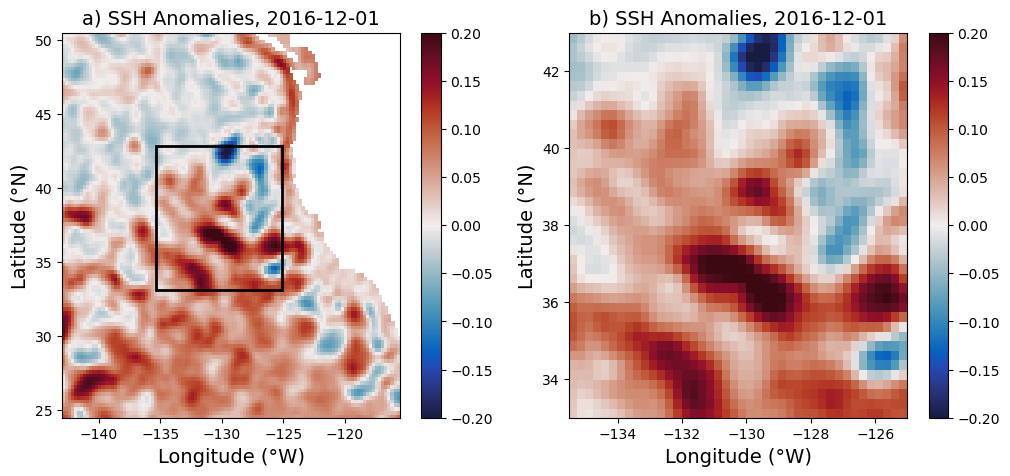

In [12]:
plt.figure(figsize = (12, 5))
plt.subplot(121)
plt.title('a) SSH Anomalies, ' + str(date_time[0])[:10], fontsize = 14)
plt.pcolor((360 - avisso_ds.lon[30:140]) * -1, avisso_ds.lat, SSHA0[:, 30:140], vmin = -0.2, vmax = .2, cmap = cmo.cm.balance)
plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)

import matplotlib.patches as mpatches
left, bottom, width, height = (lon[0], lat[0],
                               lon[-1] - lon[0],
                               lat[-1]- lat[0])
rect=mpatches.Rectangle((left,bottom),width,height, #latidx_south:latidx_north, 
                        fill=False,
                        color="black",
                       linewidth=2)
                       #facecolor="red")
plt.gca().add_patch(rect)
    
plt.colorbar()
plt.subplot(122)
plt.title('b) SSH Anomalies, ' + str(date_time[0])[:10], fontsize = 14)
plt.pcolor(lon, lat, SSHA[:, :, day0], vmin = -0.2, vmax = .2, cmap = cmo.cm.balance)
plt.colorbar()
plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
plt.savefig('AVISO_SSHA_10deg'+ str(date_time[0])[:10]  +'.png')

### parameters

In [13]:
Phi0 = lat.mean() # central latitude (φ0)
Omega = 7.27e-5 # Ω is the angular speed of the earth
Earth_radius = 6.371e6 / 1e5 # meters
Beta = 2 * Omega * np.cos(Phi0) / Earth_radius
f0 =  2 * Omega * np.sin(Phi0) #1.0313e-4 
f0, Beta

(4.309199134434463e-05, 2.1796846310544133e-06)

#### Rossby wave vertical modes

In [14]:
MModes = 1

#### define wavenumber interval based on domain size

In [15]:
L_lat = 10 # domain latitude length degree 
L_lon = 10 # domain lognitude length

domain_factor = 1.1 # the smaller, the less waves

l_interval = 2 * np.pi / (domain_factor * L_lat) # zonal wavemenumber interval
k_interval = 2 * np.pi / (domain_factor * L_lon) # longitutional wavemenumber interval

lamda_min = 1.2 # 100km = 1 degree minimum wavelength resolved , the smaller, the more waves

#l_min = 0
#l_max = 2 * np.pi / lamda_min
#k_max = l_max
#k_min = -1 * l_max
k_min = 0  # stg:  changes to maintain consistent variable names
k_max = 2 * np.pi / lamda_min
l_max = k_max
l_min = -1 * k_max
print(k_max)

5.235987755982989


In [16]:
#l_n_orig = np.arange(k_min, k_max, k_interval) # degree^-1
#k_n_orig = np.arange(l_min, l_max, l_interval) # degree^-1
k_n_orig = np.arange(k_min, k_max, k_interval) # degree^-1  ###stg:  changes for variable name consistency
l_n_orig = np.arange(l_min, l_max, l_interval) # degree^-1
l_n = l_n_orig.reshape(len(l_n_orig), MModes) #* 0 # lon, zonal propagration 
k_n = k_n_orig.reshape(len(k_n_orig), MModes) #* 0 # lat, meridonal propagration

In [17]:
strat_ds = xr.open_dataset('./stratification_sample_ccs.nc')

#### Wavespeed and Rossby wave deformation radius

In [18]:
Psi = strat_ds.Psi.data
Rm = 5e4  / 1e5 # 50 km to degree
wavespeed = Rm * f0  # deg / s strat_ds.C2[:MModes].data
Rm = np.array([Rm]) #unit: degree 
wavespeed, Rm , np.sqrt(strat_ds.C2[:MModes].data)/1e5 # deg/s

(2.1545995672172316e-05, array([0.5]), array([2.85035991e-05]))

#### evaluate the skill of each wave

In [19]:
skill, SSHA_vector, Iindex, Jindex, Tindex = skill_matrix(MSLA0, Psi, l_n, k_n, MModes, Rm, lon, lat, T_time[day0:day1])

In [20]:
skill.shape, SSHA_vector.shape

((19, 10, 1), (67200,))

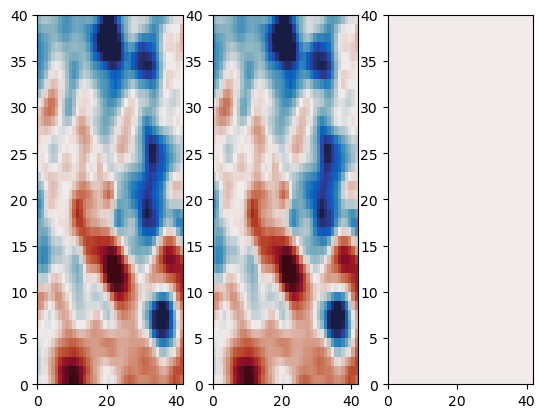

In [21]:
plt.subplot(131)
plt.pcolormesh(MSLA0[:,:,39], cmap = cmo.cm.balance, vmin = -.15, vmax = .15) 
plt.subplot(132)
plt.pcolormesh(SSHA_vector[(39*40*42)+0:(39*40*42)+40*42].reshape(40,42), cmap = cmo.cm.balance, vmin = -.15, vmax = .15) 
plt.subplot(133)
plt.pcolormesh(MSLA0[:,:,39]-SSHA_vector[(39*40*42)+0:(39*40*42)+40*42].reshape(40,42), cmap = cmo.cm.balance, vmin = -.15, vmax = .15) 

#### Number of models/waves

In [22]:
M = k_n.size * l_n.size
M

190

In [23]:
kk, ll = np.meshgrid(l_n, k_n)

#### Signal to noise ratio matrix

In [24]:
counter = 0
exp=-2
k0 = l_n.max() # flat at or below k0 

kl, P_over_R = np.zeros(2 * M), np.zeros([2 * M, 2 * M])
p_diagonal = np.zeros([2 * M])
k_, l_ = np.zeros(len(l_n)*len(k_n)), np.zeros(len(l_n)*len(k_n))
R = 0.01 # noise = 1. cm
#R=0.
counter=0

for kk in k_n:
    for ll in l_n:
        k_[counter] , l_[counter]  = kk, ll
        kl[counter] =  np.sqrt(kk ** 2 + ll ** 2) # wavenumber
        p_diagonal[2 * counter] = (kl[counter]+k0) ** exp 
        p_diagonal[2 * counter + 1] = (kl[counter]+k0) ** exp 
        counter += 1   

P_over_R = np.zeros([2 * M, 2 * M])
p_factor = .16/p_diagonal.sum() # variance of the model,  convert sum of variance from waven number to meter
np.fill_diagonal(P_over_R[:],  R / p_diagonal / p_factor)
# for kk in l_n:
#     for ll in k_n:
#         kl[2*counter] = np.sqrt(kk ** 2 + ll ** 2)
#         kl[2*counter+1] = np.sqrt(kk ** 2 + ll ** 2)
#         P_over_R[2*counter, 2*counter] = kl[2*counter] ** exp
#         P_over_R[2*counter+1, 2*counter+1] = kl[2*counter + 1] ** exp
#         counter += 1

/var/folders/1w/2s58vmmj44x13x6_fxjpksb00000gq/T/ipykernel_79582/1595550062.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  k_[counter] , l_[counter]  = kk, ll
/var/folders/1w/2s58vmmj44x13x6_fxjpksb00000gq/T/ipykernel_79582/1595550062.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  kl[counter] =  np.sqrt(kk ** 2 + ll ** 2) # wavenumber


In [25]:
T_time.shape

(1616,)

In [26]:
H_all = build_h_matrix(MSLA0, MModes, k_n, l_n, lon, lat, T_time[:], Psi, Rm, day0)

In [27]:
Beta

2.1796846310544133e-06

In [28]:
H_all.shape, P_over_R.shape

((67200, 380), (380, 380))

In [29]:
ds_H_all = xr.Dataset(data_vars={'H_all' : (["values", "wavenumbers"], H_all)},
                      attrs = dict(description='H matrix from fit to AVISO SSH, fit with 40-day record.'))


In [30]:
ds_H_all.to_netcdf('./H_all' + str(date_time[0])[:10] +'_' + str(k_n.size * l_n.size) +'waves_data'+ str(int((day1 - day0))) +'days.nc')

In [31]:
H_all[0:10,0:10]


array([[ 0.82615763,  0.3422057 , -0.65447954, -0.60934203,  0.40027121,
         0.79964   , -0.09558846, -0.88910293, -0.22114805,  0.86644949],
       [ 0.82615763,  0.3422057 , -0.65447954, -0.60934203,  0.40027121,
         0.79964   , -0.09558846, -0.88910293, -0.22114805,  0.86644949],
       [ 0.82615763,  0.3422057 , -0.65447954, -0.60934203,  0.40027121,
         0.79964   , -0.09558846, -0.88910293, -0.22114805,  0.86644949],
       [ 0.82615763,  0.3422057 , -0.65447954, -0.60934203,  0.40027121,
         0.79964   , -0.09558846, -0.88910293, -0.22114805,  0.86644949],
       [ 0.82615763,  0.3422057 , -0.65447954, -0.60934203,  0.40027121,
         0.79964   , -0.09558846, -0.88910293, -0.22114805,  0.86644949],
       [ 0.82615763,  0.3422057 , -0.65447954, -0.60934203,  0.40027121,
         0.79964   , -0.09558846, -0.88910293, -0.22114805,  0.86644949],
       [ 0.82615763,  0.3422057 , -0.65447954, -0.60934203,  0.40027121,
         0.79964   , -0.09558846, -0.88910293

#### solve for amplitudes

In [32]:
amp, ssh_estimated = inversion(SSHA_vector, H_all, P_over_R)

7026.208986466872


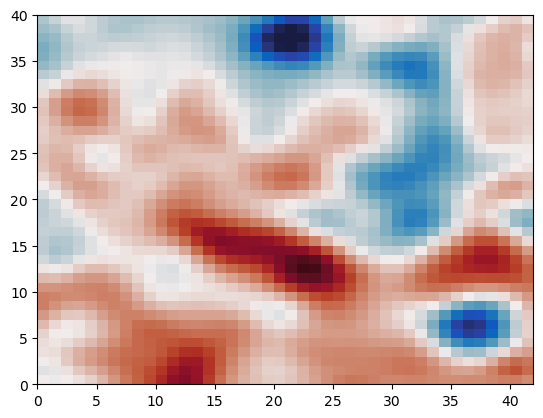

In [33]:
plt.pcolormesh(ssh_estimated[(40*42)*30:(40*42)*31].reshape(40,42), cmap = cmo.cm.balance, vmin = -.2, vmax = .2)

### Fit AVISO data to Rossby wave model

In [34]:
ssh_estimated.shape
67200/40/42

40.0

In [35]:
SSHA_masked.shape

(40, 42, 1616)

In [36]:
SSHA_predicted = np.zeros([time_range, MSLA0[:, :, 0:1].size])
SSHA_true = np.zeros([time_range, MSLA0[:, :, 0:1].size])
variance_explained_inverse  = np.zeros(time_range)
MSLA_fwrd = np.zeros([MSLA0.shape[0], MSLA0.shape[1], time_range])
for day in range(time_range):
    # SSH data
    MSLA = SSHA_masked[:, :, day0+day: day0+day+1]
    # Build basis function H matrix
    H_all = build_h_matrix(MSLA, MModes, k_n, l_n, lon, lat, T_time, Psi, Rm, day0 + day)
    # forecast SSH
    SSHA_predicted[day], SSHA_true[day], variance_explained_inverse[day] = forecast_ssh(MSLA, amp,  H_all)
    # reverse vector
    MSLA_fwrd[:, :, day:day+1] = reverse_vector(MSLA, SSHA_predicted[day])

#     plt.figure(figsize = (15, 5))

#     plt.subplot(131)
#     plt.pcolormesh(lon, lat, MSLA[:, :, 0], cmap = cmo.cm.balance, vmin = -.15, vmax = .15) 
#     plt.colorbar()
#     plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
#     plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
#     plt.title('a) AVISO data ' + str(date_time[day])[:10], fontsize = 14)

#     plt.subplot(132)
#     plt.pcolormesh(lon, lat, MSLA_fwrd[:, :, day], vmin = -.15, vmax = .15, cmap = cmo.cm.balance)
#     plt.colorbar()
#     plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
#     plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
#     plt.title('b) Rossby wave model, 450 waves', fontsize = 14)

#     residual = MSLA[:, :, 0] - MSLA_fwrd[:, :, day] 
#     plt.subplot(133)
#     plt.pcolormesh(lon, lat, residual, cmap = cmo.cm.balance, vmin = -.15, vmax = .15)
#     plt.colorbar()
#     plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
#     plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
#     plt.title('c) Residual variance ' + str((variance_explained_inverse[day]) * 100)[:4] + '%', fontsize = 14)
    
#     plt.tight_layout()
#     #plt.close()
#     plt.savefig('./forward_model/diag_ssh_' + str(date_time[day0+day])[:10] +'_' + str(skill.size) + 'waves.png', dpi = 300)

In [37]:
MSLA_fwrd.shape, MSLA.shape, time_range

((40, 42, 80), (40, 42, 1), 80)

In [38]:
ds_output = xr.Dataset(data_vars={'l_n' : l_n[:, 0],
                                  'k_n' : k_n[:, 0],
                                  'Amplitudes': amp,
                                  'variance_explained': (('time'), 1-variance_explained_inverse),
                                  'MSLA_forward' : (('YC', 'XC', 'time'), MSLA_fwrd[:, :, :time_range]),
                                  'Rm': Rm,
                                  'XC' : (('XC'), lon.data), 
                                  'YC' : (('YC'), lat.data),
                                  'time': date_time[:time_range]},
                      attrs = dict(description=('Data sample of the selected waves, amplitudes, estimated SSH anomalies and residual, fit with ' 
                                                + str(day1 - day0) + '-day prior data.')))

In [39]:
'residual variance', variance_explained_inverse, date_time[:time_range]

('residual variance',
 array([0.20521664, 0.19039173, 0.17657443, 0.16264307, 0.1490021 ,
        0.13590611, 0.12294611, 0.11016143, 0.09919928, 0.08806218,
        0.07708251, 0.06669116, 0.05639971, 0.04658673, 0.03850986,
        0.03149068, 0.02563329, 0.02115483, 0.01847379, 0.01749181,
        0.01878164, 0.02258089, 0.02843992, 0.03612493, 0.04611721,
        0.05719372, 0.07038622, 0.08296349, 0.09796339, 0.11395383,
        0.13160874, 0.14702322, 0.16267526, 0.17914503, 0.1976988 ,
        0.21549397, 0.23279446, 0.25245487, 0.27428036, 0.29602783,
        0.31824036, 0.34199352, 0.36882442, 0.3943822 , 0.42222349,
        0.45132785, 0.4771861 , 0.50276993, 0.5289804 , 0.5560221 ,
        0.58421481, 0.61085282, 0.6368062 , 0.6614063 , 0.68365473,
        0.70941407, 0.73437675, 0.75757452, 0.78450946, 0.81097747,
        0.83679927, 0.86169864, 0.88654351, 0.90909743, 0.93255252,
        0.95419317, 0.97606485, 0.99801064, 1.01812465, 1.03818762,
        1.05656472, 1.0748

Text(0.5, 1.0, 'residual')

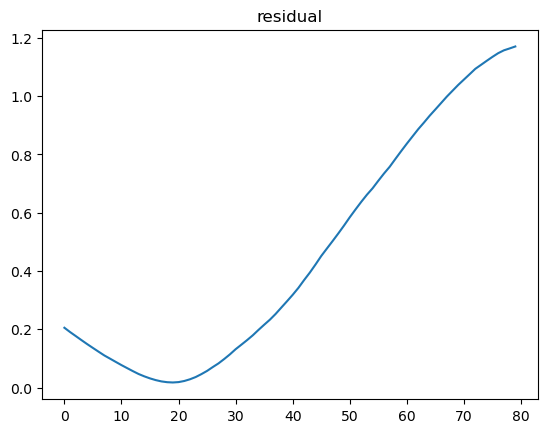

In [40]:
plt.plot(variance_explained_inverse[:])
plt.title('residual')

In [41]:
#ds_output.to_netcdf('./rossby_wave_estimate_' + str(date_time[0])[:10] +'_' + str(k_n.size * l_n.size) +'waves.nc')
ds_output.to_netcdf('./rossby_wave_estimate_' + str(date_time[0])[:10] +'_' + str(k_n.size * l_n.size) +'waves_data'+ str(int((day1 - day0))) +'days.nc')

### Plot the Rossby wave model versus the AVISO data

In [42]:
time = T_time[day0:day0+time_range] / 86400

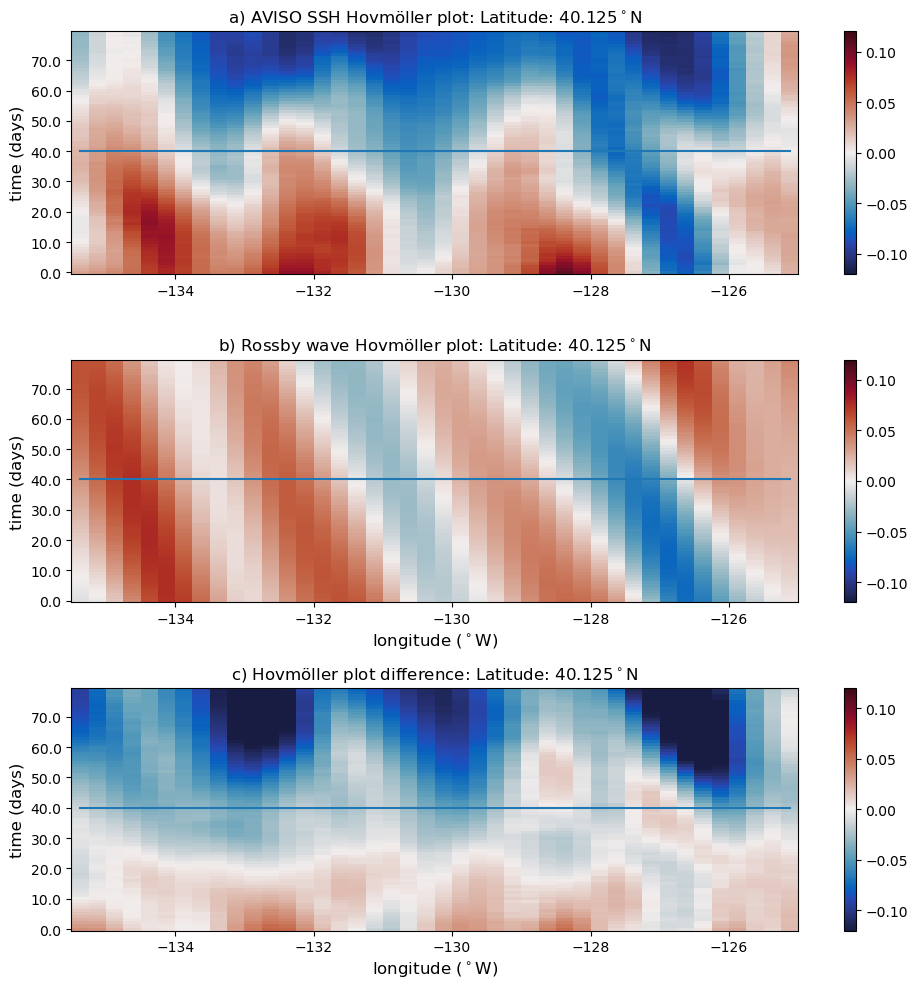

In [43]:
selected_lat = 28
plt.figure(figsize = (10, 10))     
SSHA_slice= SSHA_masked[selected_lat, :, day0:day0+time_range].T
plt.subplot(311) 
plt.title('a) AVISO SSH Hovmöller plot: Latitude: ' + str(lat[selected_lat]) + '$^\circ$N', fontsize = 12)
plt.pcolormesh(lon, time, SSHA_slice, cmap = cmo.cm.balance, vmin = -.12, vmax = .12)
plt.plot(lon, np.repeat(time[day1 - day0],  len(lon)))
plt.colorbar()
plt.ylabel('time (days)', fontsize = 12)
plt.yticks(time[0::10], time[0::10] - time[0])


plt.subplot(312) 
plt.title('b) Rossby wave Hovmöller plot: Latitude: ' + str(lat[selected_lat]) + '$^\circ$N', fontsize = 12)
plt.pcolormesh(lon, time, MSLA_fwrd[selected_lat, :, :time_range].T, cmap = cmo.cm.balance, vmin = -.12, vmax = .12)
plt.plot(lon, np.repeat(time[day1 - day0], len(lon)))
plt.colorbar()
plt.xlabel('longitude ($^\circ$W)', fontsize = 12)
plt.ylabel('time (days)', fontsize = 12)
plt.yticks(time[0::10], time[0::10] - time[0])

plt.subplot(313) 
plt.title('c) Hovmöller plot difference: Latitude: ' + str(lat[selected_lat]) + '$^\circ$N', fontsize = 12)
plt.pcolormesh(lon, time, SSHA_slice - MSLA_fwrd[selected_lat, :, :time_range].T,cmap = cmo.cm.balance, vmin = -.12, vmax = .12)
plt.plot(lon, np.repeat(time[day1 - day0], len(lon)))
plt.colorbar()
plt.xlabel('longitude ($^\circ$W)', fontsize = 12)
plt.ylabel('time (days)', fontsize = 12)
plt.yticks(time[0::10], time[0::10] - time[0])

plt.tight_layout()
plt.savefig('./Hovmoller' +'_lat_' + str(selected_lat) + '.png', dpi = 300)

In [44]:
time

array([736665., 736666., 736667., 736668., 736669., 736670., 736671.,
       736672., 736673., 736674., 736675., 736676., 736677., 736678.,
       736679., 736680., 736681., 736682., 736683., 736684., 736685.,
       736686., 736687., 736688., 736689., 736690., 736691., 736692.,
       736693., 736694., 736695., 736696., 736697., 736698., 736699.,
       736700., 736701., 736702., 736703., 736704., 736705., 736706.,
       736707., 736708., 736709., 736710., 736711., 736712., 736713.,
       736714., 736715., 736716., 736717., 736718., 736719., 736720.,
       736721., 736722., 736723., 736724., 736725., 736726., 736727.,
       736728., 736729., 736730., 736731., 736732., 736733., 736734.,
       736735., 736736., 736737., 736738., 736739., 736740., 736741.,
       736742., 736743., 736744.])

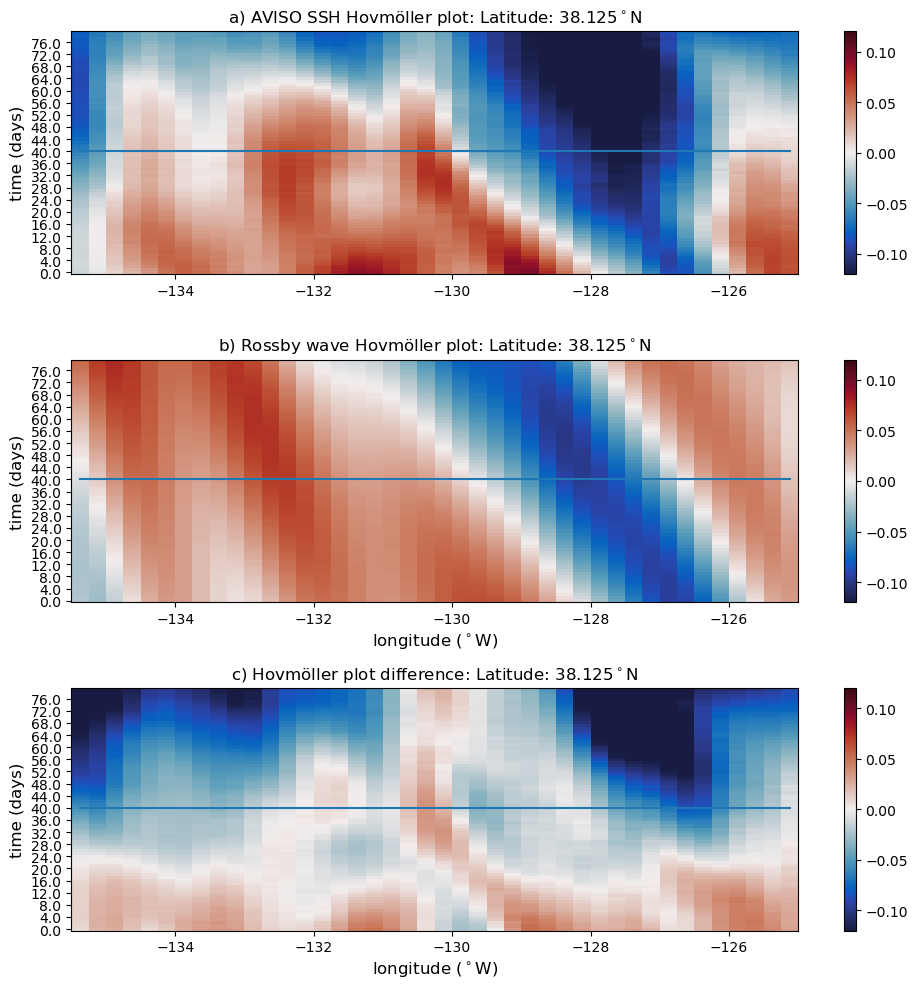

In [45]:
selected_lat = 20
plt.figure(figsize = (10, 10))

SSHA_slice = SSHA_masked[ selected_lat, :, day0:day0+time_range].T
plt.subplot(311) 
plt.title('a) AVISO SSH Hovmöller plot: Latitude: ' + str(lat[selected_lat]) + '$^\circ$N', fontsize = 12)
plt.pcolormesh(lon, time, SSHA_slice, cmap = cmo.cm.balance, vmin = -.12, vmax = .12)
plt.plot(lon, np.repeat(time[day1 - day0], len(lon)))
plt.colorbar()
plt.ylabel('time (days)', fontsize = 12)
plt.yticks(time[0::4], time[0::4] - time[0])


plt.subplot(312) 
plt.title('b) Rossby wave Hovmöller plot: Latitude: ' 
          + str(lat[selected_lat]) + '$^\circ$N', fontsize = 12)
plt.pcolormesh(lon, time, MSLA_fwrd[selected_lat, :, :time_range].T, cmap = cmo.cm.balance, vmin = -.12, vmax = .12)
plt.plot(lon, np.repeat(time[day1 - day0], len(lon)))
plt.colorbar()
plt.xlabel('longitude ($^\circ$W)', fontsize = 12)
plt.ylabel('time (days)', fontsize = 12)
plt.yticks(time[0::4], time[0::4] - time[0])

plt.subplot(313) 
plt.title('c) Hovmöller plot difference: Latitude: ' 
          + str(lat[selected_lat]) + '$^\circ$N', fontsize = 12)
plt.pcolormesh(lon, time, SSHA_slice - MSLA_fwrd[selected_lat, :, :time_range].T,
               cmap = cmo.cm.balance, vmin = -.12, vmax = .12)
plt.plot(lon, np.repeat(time[day1 - day0], len(lon)))
plt.colorbar()
plt.xlabel('longitude ($^\circ$W)', fontsize = 12)
plt.ylabel('time (days)', fontsize = 12)
plt.yticks(time[0::4], time[0::4] - time[0])

plt.tight_layout()
# plt.savefig('./hovmoller/diag_Hovmoller' +'_lat_' + str(selected_lat) + '.png', dpi = 300)

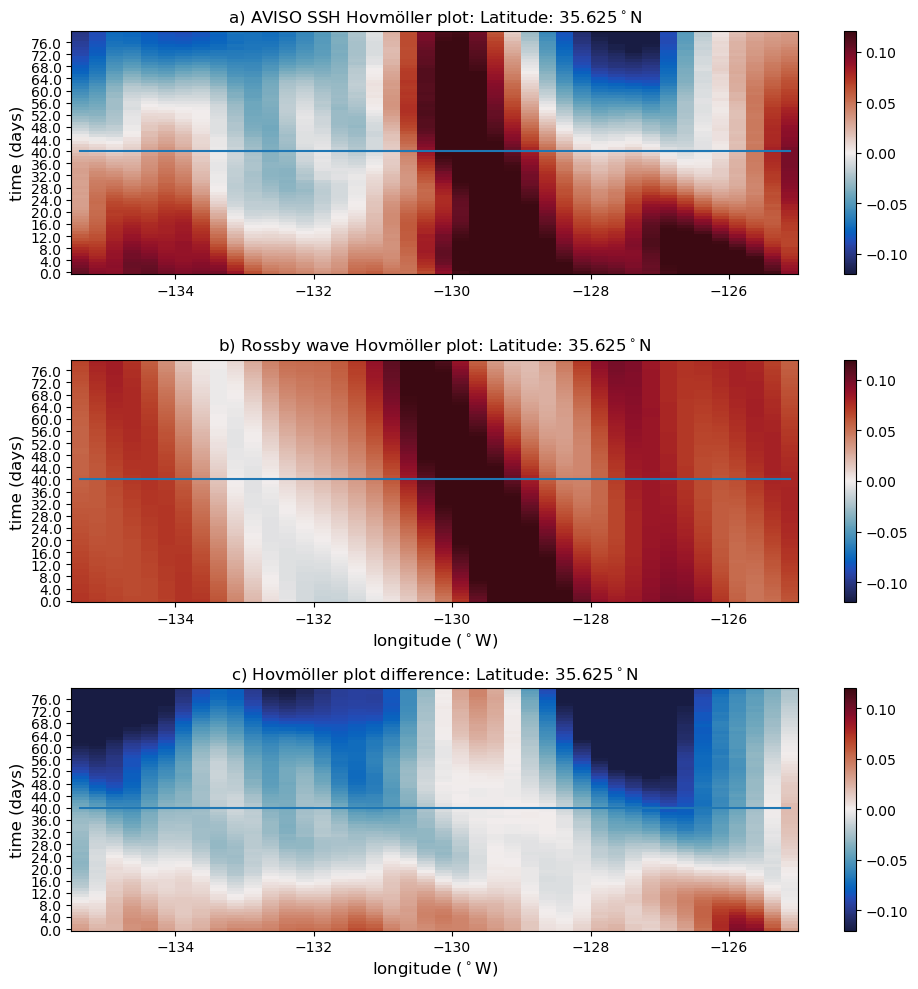

In [46]:
selected_lat = 10
plt.figure(figsize = (10, 10))

plt.subplot(311) 
plt.title('a) AVISO SSH Hovmöller plot: Latitude: ' + str(lat[selected_lat]) + '$^\circ$N', fontsize = 12)
plt.pcolormesh(lon, time,  SSHA_masked[ selected_lat,:, day0:day0+time_range].T, cmap = cmo.cm.balance, vmin = -.12, vmax = .12)
plt.plot(lon, np.repeat(time[day1 - day0], len(lon)))
plt.colorbar()
plt.ylabel('time (days)', fontsize = 12)
plt.yticks(time[0::4], time[0::4] - time[0])


plt.subplot(312) 
plt.title('b) Rossby wave Hovmöller plot: Latitude: ' 
          + str(lat[selected_lat]) + '$^\circ$N', fontsize = 12)
plt.pcolormesh(lon, time, MSLA_fwrd[ selected_lat, :, :time_range].T, cmap = cmo.cm.balance, vmin = -.12, vmax = .12)
plt.plot(lon, np.repeat(time[day1 - day0], len(lon)))
plt.colorbar()
plt.xlabel('longitude ($^\circ$W)', fontsize = 12)
plt.ylabel('time (days)', fontsize = 12)
plt.yticks(time[0::4], time[0::4] - time[0])

plt.subplot(313) 
plt.title('c) Hovmöller plot difference: Latitude: ' 
          + str(lat[selected_lat]) + '$^\circ$N', fontsize = 12)
plt.pcolormesh(lon, time, SSHA_masked[ selected_lat, :, day0:day0+time_range].T - MSLA_fwrd[selected_lat, :, :time_range].T,
               cmap = cmo.cm.balance, vmin = -.12, vmax = .12)
plt.plot(lon, np.repeat(time[day1 - day0], len(lon)))
plt.colorbar()
plt.xlabel('longitude ($^\circ$W)', fontsize = 12)
plt.ylabel('time (days)', fontsize = 12)
plt.yticks(time[0::4], time[0::4] - time[0])

plt.tight_layout()
# plt.savefig('./hovmoller/diag_Hovmoller' +'_lat_' + str(selected_lat) + '.png', dpi = 300)

## Diagnostics

### Phase speed is faster for longer waves. the maximum zonal phase speed is Cx = $\beta * R^2$. For those waves, the propagration speed for the ROssby waves: 

In [47]:
Beta * Rm ** -2, 'degree/s', Beta * Rm ** -2 * 1e5, 'm/s'

(array([8.71873852e-06]), 'degree/s', array([0.87187385]), 'm/s')

In [48]:
Beta / Rm ** -2  * 86400 * 20, 'degree per 20 days',Beta * Rm ** -2 * 1e5 * 86400 * 20 /1000, 'km' #Beta / (1/Rm**2)

(array([0.94162376]), 'degree per 20 days', array([1506.59801698]), 'km')

### Compare persistence error to forecast error: do wave dynamics predict SSH anomalies better than persistence? 

## plot persistence versus prediction error

In [49]:
persistence = SSHA.data[:, :, day0:day0+time_range] - SSHA.data[:, :, day0:day0+1]
prediction_err = MSLA_fwrd[:, :, :time_range] - SSHA.data[:, :, day0:day0+time_range]
rms_persistence = np.zeros(persistence.shape[-1])
rms_prediction_err = np.zeros(prediction_err.shape[-1])
for t in range(persistence.shape[-1]):
    #rms_persistence_err[t] = np.sqrt(np.mean(persistence_err[:, :, t] ** 2)) / np.sqrt(np.mean(SSHA[:, :, 0:1].data ** 2))
    rms_persistence[t] = np.sqrt(np.mean(persistence[:, :, t] ** 2)) / np.sqrt(np.mean(SSHA[:, :, day0 + t :day0 + 1 + t].data ** 2)) 
    # day by day persistence
    rms_prediction_err[t] = np.sqrt(np.mean(prediction_err[:, :, t] ** 2)) / np.sqrt(np.mean(SSHA[:, :, day0 + t].data ** 2))

In [50]:
rms_persistence

array([0.        , 0.03268493, 0.0631289 , 0.09607353, 0.12910933,
       0.16341036, 0.19611236, 0.22916593, 0.26163252, 0.29715388,
       0.33471912, 0.37074656, 0.40832593, 0.44702264, 0.48644911,
       0.52507698, 0.56674028, 0.60810166, 0.6493935 , 0.68834799,
       0.72723245, 0.7647904 , 0.80210909, 0.83765114, 0.8709569 ,
       0.90284267, 0.93332044, 0.95937201, 0.98633578, 1.01320182,
       1.03684331, 1.05678219, 1.07251512, 1.08772233, 1.10551747,
       1.12188952, 1.1352167 , 1.15141331, 1.16875216, 1.18475703,
       1.20026394, 1.21286062, 1.22950505, 1.24351595, 1.25737649,
       1.27230698, 1.28432231, 1.2955018 , 1.30700766, 1.3179694 ,
       1.32678106, 1.33496393, 1.34209725, 1.34922161, 1.35516349,
       1.36197233, 1.36970335, 1.37744727, 1.38674762, 1.39565798,
       1.40302608, 1.40987346, 1.41785468, 1.42342443, 1.43138178,
       1.43846735, 1.44550154, 1.4534083 , 1.46014434, 1.4672431 ,
       1.47294968, 1.47833621, 1.48442102, 1.4899298 , 1.49344

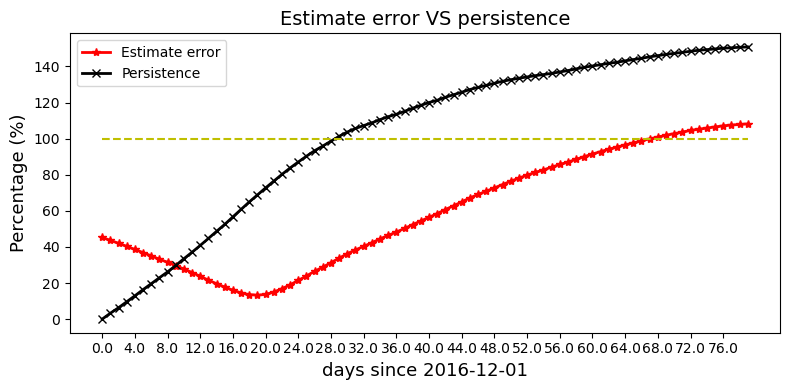

In [51]:
plt.figure(figsize = (8, 4))
plt.plot(time[:time_range],  rms_prediction_err[:time_range] * 100,  
         '-*',linewidth = 2, color = 'r', label = 'Estimate error')
plt.plot(time[:time_range], (rms_persistence[:time_range]) * 100,  
         '-x',linewidth = 2, color = 'k', label = 'Persistence')
plt.plot(time, np.repeat(100, len(time)),linestyle = '--',  color = 'y')
plt.xticks(time[:time_range][0::4], time[:time_range][0::4] - time[0])
plt.ylabel('Percentage (%)', fontsize = 13)
plt.xlabel('days since ' + str(date_time[0])[:10], fontsize = 13)
plt.title('Estimate error VS persistence', fontsize = 14)
plt.legend()
plt.tight_layout()
plt.savefig('./prediction_vs_persistence/diag_estimate_err_vs_persistence_' + str(date_time[day0])[:10] + '.png', dpi = 300)

### Make an ensemble of persistence

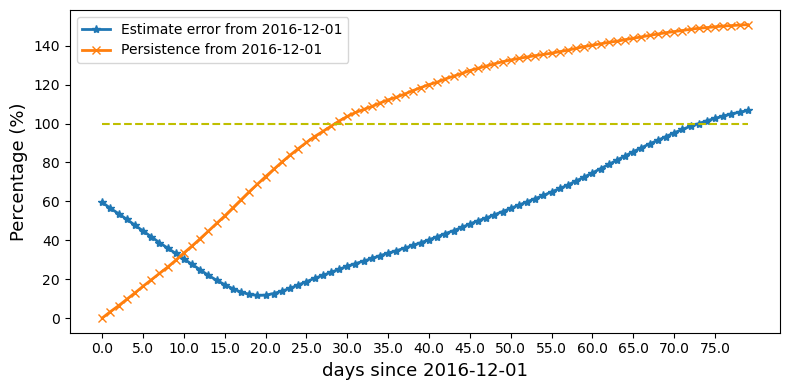

In [52]:
persistence0 = SSHA.data[:, :, day0:day0+time_range] - SSHA.data[:, :, day0:day0+1]
persistence1 = SSHA.data[:, :, day0:day0+time_range] - SSHA.data[:, :, day1:day1+1]
prediction_err = MSLA_fwrd[:, :, :time_range] - SSHA.data[:, :, day0:day0+time_range]
rms_persistence0 = np.zeros(persistence.shape[-1])
rms_persistence1 = np.zeros(persistence.shape[-1])
rms_prediction_err = np.zeros(prediction_err.shape[-1])

for t in range(persistence.shape[-1]):
    rms_persistence0[t] = np.sqrt(np.mean(persistence0[:, :, t] ** 2)) / np.sqrt(np.mean(SSHA[:, :, day0 + t :day0 + t + 1].data ** 2)) # day 0
    rms_persistence1[t] = np.sqrt(np.mean(persistence1[:, :, t] ** 2)) / np.sqrt(np.mean(SSHA[:, :, day1 + t :day1 + t + 1].data ** 2)) # day 70
    rms_prediction_err[t] = np.sqrt(np.mean(prediction_err[:, :, t] ** 2)) / np.sqrt(np.mean(SSHA[:, :, day1 + t :day1 + t + 1].data ** 2))
    
plt.figure(figsize = (8,4))
plt.plot(time[:time_range],  rms_prediction_err[:time_range] * 100,  
         '-*',linewidth = 2,  label = 'Estimate error from ' + str(date_time[0])[:10])
plt.plot(time[:time_range], (rms_persistence0[:time_range]) * 100,  
         '-x',linewidth = 2,  label = 'Persistence from ' + str(date_time[0])[:10])
plt.plot(time, np.repeat(100, len(time)),linestyle = '--',  color = 'y')
plt.xticks(time[:time_range][0::5], time[:time_range][0::5] - time[0])
plt.ylabel('Percentage (%)', fontsize = 13)
plt.xlabel('days since ' + str(date_time[0])[:10], fontsize = 13)
plt.legend()
plt.tight_layout()
plt.savefig('./prediction_vs_persistence/diag_fwd_prediction_err_vs_persistence_' 
            + str(M) + '_waves_' + str(int((day1 - day0)*5)) + 'days.png', dpi = 300)

In [53]:
str(date_time[0])

'2016-12-01T00:00:00.000000000'